# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [3]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [5]:
df = pd.read_csv('../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


<Axes: xlabel='ACTION', ylabel='count'>

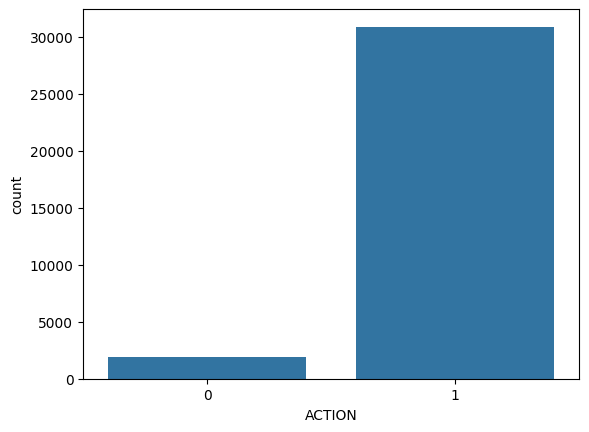

In [7]:
print(df['ACTION'].mean())
sns.countplot(x='ACTION', data=df)

In [8]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [9]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



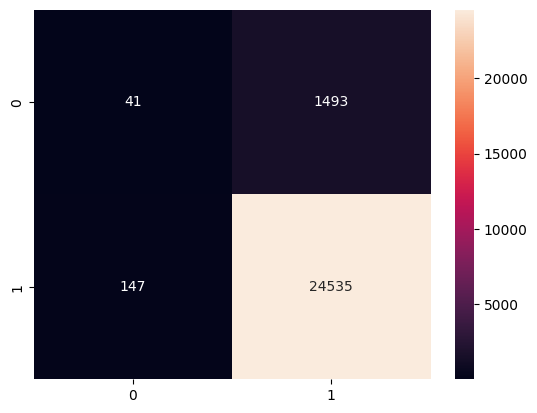

In [10]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [11]:
p_values = [1, 2, 4, 6]
cv_scores = []

for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=10, p=p)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append((p, scores.mean(), scores.std()))

for p, mean_score, std_score in cv_scores:
    print(f"p={p}: Mean Accuracy = {mean_score:.4f}, Std = {std_score:.4f}")

p=1: Mean Accuracy = 0.9443, Std = 0.0010
p=2: Mean Accuracy = 0.9446, Std = 0.0008
p=4: Mean Accuracy = 0.9445, Std = 0.0009
p=6: Mean Accuracy = 0.9441, Std = 0.0006


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [12]:
data = pd.DataFrame(index=df.index)
n_folds = 3

for col_name in df.columns:
    if col_name == 'ACTION':
        continue
        
    for i in range(n_folds):
        fold_mask = (df.index % n_folds == i)
        counts = df.loc[~fold_mask, col_name].value_counts()
        successes = df.loc[(df['ACTION'] == 1) & ~fold_mask, col_name].value_counts()
        
        data[f'{col_name}_counts_fold_{i}'] = df[col_name].apply(lambda x: counts.get(x, 0))
        data[f'{col_name}_successes_fold_{i}'] = df[col_name].apply(lambda x: successes.get(x, 0))
        data[f'{col_name}_smooth_fold_{i}'] = (data[f'{col_name}_successes_fold_{i}'] + 1) / (data[f'{col_name}_counts_fold_{i}'] + 2)

data

,RESOURCE_counts_fold_0,RESOURCE_successes_fold_0,RESOURCE_smooth_fold_0,RESOURCE_counts_fold_1,RESOURCE_successes_fold_1,RESOURCE_smooth_fold_1,RESOURCE_counts_fold_2,RESOURCE_successes_fold_2,RESOURCE_smooth_fold_2,MGR_ID_counts_fold_0,...,ROLE_FAMILY_smooth_fold_2,ROLE_CODE_counts_fold_0,ROLE_CODE_successes_fold_0,ROLE_CODE_smooth_fold_0,ROLE_CODE_counts_fold_1,ROLE_CODE_successes_fold_1,ROLE_CODE_smooth_fold_1,ROLE_CODE_counts_fold_2,ROLE_CODE_successes_fold_2,ROLE_CODE_smooth_fold_2
0,1,1,0.666667,3,3,0.800000,2,2,0.750000,36,...,0.941673,2390,2312,0.966973,2425,2353,0.969922,2351,2269,0.964726
1,22,21,0.916667,17,16,0.894737,21,21,0.956522,8,...,0.946996,53,51,0.945455,55,52,0.929825,54,53,0.964286
2,2,2,0.750000,2,2,0.750000,0,0,0.500000,3,...,0.912969,860,767,0.890951,831,732,0.879952,821,735,0.894289
3,0,0,0.500000,1,1,0.666667,1,1,0.666667,42,...,0.941673,3097,2841,0.917070,3057,2820,0.922197,3144,2897,0.921170
4,6,6,0.875000,6,6,0.875000,4,4,0.833333,2,...,0.851406,48,41,0.840000,52,44,0.833333,50,45,0.884615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,35,31,0.864865,31,29,0.909091,36,32,0.868421,21,...,0.941673,3097,2841,0.917070,3057,2820,0.922197,3144,2897,0.921170
32765,1,1,0.666667,2,2,0.750000,1,1,0.666667,7,...,0.979167,17,17,0.947368,18,18,0.950000,13,13,0.933333
32766,106,101,0.944444,106,102,0.953704,110,107,0.964286,3,...,0.943396,0,0,0.500000,3,3,0.800000,3,3,0.800000
32767,4,4,0.833333,4,4,0.833333,6,6,0.875000,13,...,0.868071,248,229,0.920000,256,232,0.903101,284,259,0.909091


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [13]:
model = KNeighborsClassifier(n_neighbors=10, p=2)

X_train, X_test, y_train, y_test = train_test_split(data.values, y, test_size=0.2, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Средняя точность на кросс-валидации:", scores.mean(), ', Std = ', scores.std())

Средняя точность на кросс-валидации: 0.9433911882510012 , Std =  0.0008897122860721527


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

              precision    recall  f1-score   support

           0       0.63      0.33      0.43       369
           1       0.96      0.99      0.97      6185

    accuracy                           0.95      6554
   macro avg       0.79      0.66      0.70      6554
weighted avg       0.94      0.95      0.94      6554



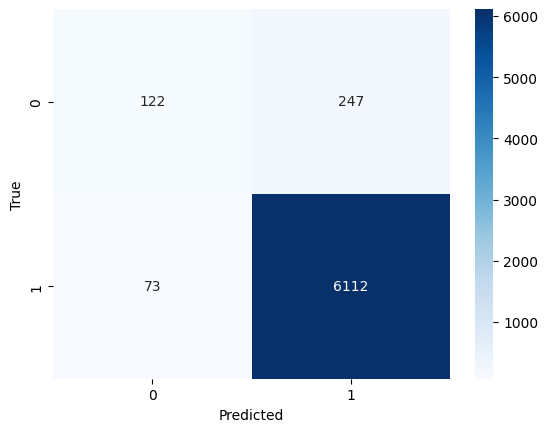

In [15]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [16]:
df_combo = df.copy()

pairwise_features = []
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
            feat1 = df.columns[i]
            feat2 = df.columns[j]
            new_feat_name = feat1 + '_' + feat2
            df_combo[new_feat_name] = df[feat1].astype(str) + '_' + df[feat2].astype(str)

df_combo

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_DEPTNAME_ROLE_TITLE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_TITLE_ROLE_FAMILY_DESC,ROLE_TITLE_ROLE_FAMILY,ROLE_TITLE_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,123472_117905,123472_117906,123472_290919,123472_117908,117905_117906,117905_290919,117905_117908,117906_290919,117906_117908,290919_117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,123125_118536,123125_118536,123125_308574,123125_118539,118536_118536,118536_308574,118536_118539,118536_308574,118536_118539,308574_118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,117884_117879,117884_267952,117884_19721,117884_117880,117879_267952,117879_19721,117879_117880,267952_19721,267952_117880,19721_117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,119993_118321,119993_240983,119993_290919,119993_118322,118321_240983,118321_290919,118321_118322,240983_290919,240983_118322,290919_118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,119569_119323,119569_123932,119569_19793,119569_119325,119323_123932,119323_19793,119323_119325,123932_19793,123932_119325,19793_119325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322,...,119993_118321,119993_240983,119993_290919,119993_118322,118321_240983,118321_290919,118321_118322,240983_290919,240983_118322,290919_118322
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145,...,122392_121143,122392_173805,122392_249618,122392_121145,121143_173805,121143_249618,121143_121145,173805_249618,173805_121145,249618_121145
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924,...,120299_124922,120299_152038,120299_118612,120299_124924,124922_152038,124922_118612,124922_124924,152038_118612,152038_124924,118612_124924
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082,...,117945_280788,117945_280788,117945_292795,117945_119082,280788_280788,280788_292795,280788_119082,280788_292795,280788_119082,292795_119082


In [18]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    fold_data = []
    for i in range(n_folds):
        fold_mask = (df_combo.index % n_folds == i)
        counts = df_combo.loc[~fold_mask, col_name].value_counts()
        successes = df_combo.loc[(df_combo['ACTION'] == 1) & ~fold_mask, col_name].value_counts()
        
        fold_counts = df_combo[col_name].apply(lambda x: counts.get(x, 0))
        fold_successes = df_combo[col_name].apply(lambda x: successes.get(x, 0))
        fold_smooth = (fold_successes + 1) / (fold_counts + 2)
        
        fold_data.append(pd.DataFrame({
            f'{col_name}_counts_fold_{i}': fold_counts,
            f'{col_name}_successes_fold_{i}': fold_successes,
            f'{col_name}_smooth_fold_{i}': fold_smooth
        }))
    
    data_combo = pd.concat([data_combo] + fold_data, axis=1)

data_combo

,RESOURCE_counts_fold_0,RESOURCE_successes_fold_0,RESOURCE_smooth_fold_0,RESOURCE_counts_fold_1,RESOURCE_successes_fold_1,RESOURCE_smooth_fold_1,RESOURCE_counts_fold_2,RESOURCE_successes_fold_2,RESOURCE_smooth_fold_2,MGR_ID_counts_fold_0,...,ROLE_FAMILY_DESC_ROLE_CODE_smooth_fold_2,ROLE_FAMILY_ROLE_CODE_counts_fold_0,ROLE_FAMILY_ROLE_CODE_successes_fold_0,ROLE_FAMILY_ROLE_CODE_smooth_fold_0,ROLE_FAMILY_ROLE_CODE_counts_fold_1,ROLE_FAMILY_ROLE_CODE_successes_fold_1,ROLE_FAMILY_ROLE_CODE_smooth_fold_1,ROLE_FAMILY_ROLE_CODE_counts_fold_2,ROLE_FAMILY_ROLE_CODE_successes_fold_2,ROLE_FAMILY_ROLE_CODE_smooth_fold_2
0,1,1,0.666667,3,3,0.800000,2,2,0.750000,36,...,0.966569,2390,2312,0.966973,2425,2353,0.969922,2351,2269,0.964726
1,22,21,0.916667,17,16,0.894737,21,21,0.956522,8,...,0.888889,53,51,0.945455,55,52,0.929825,54,53,0.964286
2,2,2,0.750000,2,2,0.750000,0,0,0.500000,3,...,0.500000,860,767,0.890951,831,732,0.879952,821,735,0.894289
3,0,0,0.500000,1,1,0.666667,1,1,0.666667,42,...,0.957020,3097,2841,0.917070,3057,2820,0.922197,3144,2897,0.921170
4,6,6,0.875000,6,6,0.875000,4,4,0.833333,2,...,0.916667,48,41,0.840000,52,44,0.833333,50,45,0.884615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,35,31,0.864865,31,29,0.909091,36,32,0.868421,21,...,0.957020,3097,2841,0.917070,3057,2820,0.922197,3144,2897,0.921170
32765,1,1,0.666667,2,2,0.750000,1,1,0.666667,7,...,0.666667,17,17,0.947368,18,18,0.950000,13,13,0.933333
32766,106,101,0.944444,106,102,0.953704,110,107,0.964286,3,...,0.750000,0,0,0.500000,3,3,0.800000,3,3,0.800000
32767,4,4,0.833333,4,4,0.833333,6,6,0.875000,13,...,0.892405,248,229,0.920000,256,232,0.903101,284,259,0.909091


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

Средняя точность на кросс-валидации: 0.9995422468052642 , Std =  0.0002854592704004567
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       1.00      1.00      1.00      6185

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00      1.00      6554



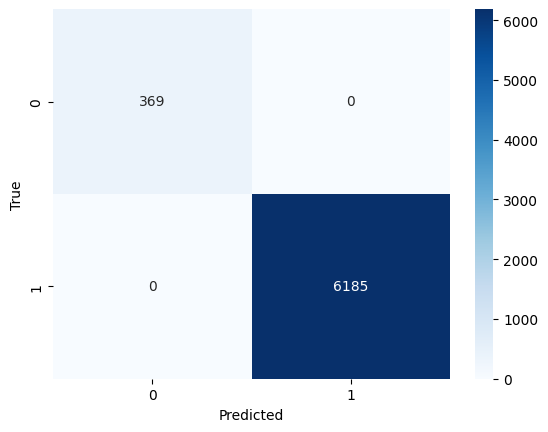

In [19]:
model = KNeighborsClassifier(n_neighbors=10, p=2)

X_train, X_test, y_train, y_test = train_test_split(data_combo.values, y, test_size=0.2, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Средняя точность на кросс-валидации:", scores.mean(), ', Std = ', scores.std())

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [20]:
def target_encode(df, target_col):
    df_target = df.copy()
    data_target = pd.DataFrame(index=df_target.index)
    for col_name in df_target.columns:
        if col_name == target_col:
            continue
        data_target[col_name + '_target_mean'] = df_target.groupby(col_name)[target_col].transform('mean')
        df_target[col_name] = data_target[col_name + '_target_mean']
    return df_target

df_target = target_encode(df, 'ACTION')
df_target

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,1.000000,1.000000,0.949222,0.956148,0.958333,0.967625,0.933440,0.942350,0.967625
1,1,0.966667,1.000000,0.949222,0.969075,0.893082,0.962963,1.000000,0.947941,0.962963
2,1,1.000000,1.000000,0.918478,0.918478,0.923077,0.889331,0.939394,0.907815,0.889331
3,1,1.000000,1.000000,0.949222,0.969075,0.989474,0.920413,0.955788,0.942350,0.920413
4,1,1.000000,1.000000,0.931159,0.876812,0.755556,0.866667,0.947368,0.837017,0.866667
...,...,...,...,...,...,...,...,...,...,...
32764,1,0.901961,0.965517,0.949222,0.956148,0.989474,0.920413,0.955788,0.942350,0.920413
32765,1,1.000000,1.000000,0.963939,0.963939,1.000000,1.000000,1.000000,0.977679,1.000000
32766,1,0.962733,1.000000,0.949222,0.954563,1.000000,1.000000,1.000000,0.974359,1.000000
32767,1,1.000000,0.687500,0.734545,0.719844,0.864947,0.913706,0.860656,0.862671,0.913706


Средняя точность на кросс-валидации: 1.0 , Std =  0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       1.00      1.00      1.00      6185

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00      1.00      6554



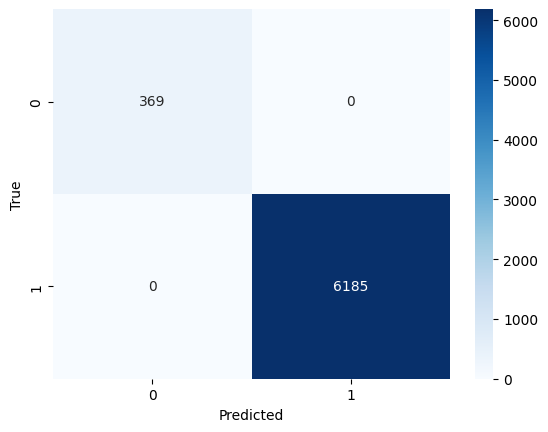

In [21]:
model = KNeighborsClassifier(n_neighbors=10, p=2)

X_train, X_test, y_train, y_test = train_test_split(df_target.values, y, test_size=0.2, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Средняя точность на кросс-валидации:", scores.mean(), ', Std = ', scores.std())

model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Сравните результаты. 

Какой недостаток есть у target encoding?

Ответ: недостаток target encoding заключается в том, что он может привести к переобучению модели. Когда в категориальном признаке есть много уникальных значений, обучение модели может быть затруднено, так как для каждого уникального значения будет посчитана своя статистическая характеристика. Это может привести к переобучению, так как модель начнет запоминать отношения между признаками в тренировочных данных, которые могут быть нерепрезентативными для тестовых данных или данных из будущего.
